In [1]:
import pandas as pd
import os
import numpy as np
from pathlib import Path
import math
import torch
from copy import deepcopy
from itertools import chain 
from torch.utils.data import Dataset
from torchtext.vocab import vocab as Vocab

import warnings
warnings.filterwarnings("ignore")


Pathing


In [2]:
#Lokalt
data_dir = 'c:\\Users\\erika\\Desktop\\Exjobb\\data'
ab_dir = 'c:\\Users\\erika\\Desktop\\Exjobb\\repo\\base'

In [2]:
#stationär
data_dir = 'c:\\Users\\erikw\\Desktop\\Exjobb kod\\data'
ab_dir = 'c:\\Users\\erikw\\Desktop\\Exjobb kod\\base'

In [ ]:
#saga
data_dir = "/home/aeerik/data/raw/"


CONFIG

In [11]:
# Budget config file
include_pheno = False
threshold_year = 1970
data_path = data_dir
ab_path = ab_dir
max_length = [51,81]
mask_prob = 0.15
embedding_dim = 32
drop_prob = 0.2

#Encoder
dim_emb = 128
dim_hidden = 128
attention_heads = 8 

#BERT
num_encoders = 2

#trainer
epochs = 5
batch_size = 32
lr = 0.001
stop_patience = 5


Vocabulary

In [ ]:
from build_vocabulary import vocab_geno
from build_vocabulary import vocab_pheno
include_pheno = False
vocabulary = vocab_geno(NCBI, include_pheno)
vocab = vocab_pheno(ab_df)
print(len(vocabulary))
print(len(vocab))


In [16]:
from build_vocabulary import vocab_geno
from build_vocabulary import vocab_pheno
from data_preprocessing import data_loader
from create_dataset import NCBIDataset

include_pheno = True
threshold_year = 1970

data_path = data_dir
ab_path = ab_dir

NCBI,ab_df = data_loader(include_pheno,threshold_year,data_path,ab_path)

max_length = [51,81]
mask_prob = 0.25
vocabulary_geno = vocab_geno(NCBI, include_pheno)
vocabulary_pheno = vocab_pheno(ab_df)

test_set = NCBIDataset(NCBI, vocabulary_geno, vocabulary_pheno, max_length, mask_prob,include_pheno)
test_set.prepare_dataset()

In [ ]:
sequences = deepcopy(NCBI['AST_phenotypes'].tolist())
max_seq_len = [max_length[0],max_length[1]]
list_idx = []
list_SR = []
for i in range(len(sequences)):
    current_seq = sequences[i]
    current_idxs = []
    current_SRs = []
    for j in range(len(current_seq)):
        item = current_seq[j].split('=')
        abs = item[0]   
        sr = item[1]
        current_idxs.append(vocabulary_pheno.lookup_indices([abs]))
        for k in range(len(sr)):
            if sr == 'R':
                current_SRs.append(1)
            else:
                current_SRs.append(0)

    if len(current_idxs) != len(current_SRs):
        print("current sequence:",current_seq, "\n", "with length:", len(current_seq))
        print("indexes:",current_idxs, "with length:", len(current_idxs))
        print("suceptability",current_SRs, "with length:", len(current_SRs))
        print('error at', j)
        print("--------------------")
    current_idxs = [int(item[0]) for item in current_idxs]
    #for i in range(0,max_length[1] - len(current_idxs)):
    #    current_idxs.append(-1)
    #for i in range(0,max_length[1] - len(current_SRs)):
    #    current_SRs.append(-1)
    list_idx.append(current_idxs)
    list_SR.append(current_SRs)
for i in range(len(list_idx)):
    if len(list_idx[i]) != len(list_SR[i]):
        print('error at', i)

In [12]:
import pandas as pd
import os
import numpy as np
from pathlib import Path
import math
import warnings
warnings.filterwarnings("ignore")

def data_loader(include_pheno, threshold_year,data_path,ab_path):
    data_dir =Path(os.path.abspath(data_path))
    os.chdir(data_dir)
    NCBI_raw = pd.read_csv('NCBI.tsv',sep='\t',header=0,low_memory=False)

    selected_data = ['collection_date', 'geo_loc_name', 'AMR_genotypes_core', 'AST_phenotypes']

    NCBI_raw = NCBI_raw[selected_data]

    NCBI_raw.rename(columns={'geo_loc_name': 'location'}, inplace=True)
    NCBI_raw.rename(columns={'collection_date': 'year'}, inplace=True)
    NCBI_raw.rename(columns={'AMR_genotypes_core': 'genes'}, inplace=True)

    NCBI = NCBI_raw[NCBI_raw['genes'].notnull()]

    unknown = ['unknown','missing','not determined', 'not collected', 'not provided', 'Not Provided', 'OUTPATIENT','missing: control sample', 'Not collected', 'Not Collected', 'not available', '-']
    
    #genomic filtering
    NCBI.loc[:,'genes'] = NCBI['genes'].replace(unknown, np.nan)

    labels = ['=PARTIAL', '=MISTRANSLATION', '=HMM', '=PARTIAL_END_OF_CONTIG']
    NCBI['genes'] = NCBI['genes'].str.split(',')
    NCBI['genes'] = NCBI['genes'].apply(lambda x: list(set([g.strip() for g in x])))
    NCBI['genes'] = NCBI['genes'].apply(lambda x: [g for g in x if not g.endswith(tuple(labels))]) 
    NCBI = NCBI[NCBI['genes'].apply(lambda x: len(x) > 0)] 

    #collection date
    NCBI.loc[:,'year'] = NCBI['year'].replace(unknown, np.nan)
    NCBI.loc[:,'year'] = NCBI['year'].str.split('-').str[0]
    NCBI.loc[:,'year'] = NCBI['year'].str.split('/').str[0]
    NCBI.loc[:,'year'] = NCBI['year'].str.split(':').str[0]

    year_idx = NCBI[NCBI['year'].astype(float) < threshold_year].index
    NCBI.drop(year_idx, inplace=True)   

    #location
    NCBI.loc[:,'location'] = NCBI['location'].replace(unknown, np.nan)
    NCBI.loc[:,'location'] = NCBI['location'].str.split(',').str[0]
    NCBI.loc[:,'location'] = NCBI['location'].str.split(':').str[0] 
    NCBI.loc[:,'location'] = NCBI['location'].replace(
        {'United Kingdom': 'UK', 'United Arab Emirates': 'UAE', 'Democratic Republic of the Congo': 'DRC',
         'Republic of the Congo': 'DRC', 'Czechia': 'Czech Republic', 'France and Algeria': 'France'})
    
    #phenotype 
    if include_pheno:
        labels = ['=ND', '=I', '=NS', "=DD"]
        NCBI = NCBI[NCBI['AST_phenotypes'].notnull()]
        print("-------------------")
        print(NCBI['AST_phenotypes'].head())
        NCBI['AST_phenotypes'] = NCBI['AST_phenotypes'].str.split(',')
        print("-------------------")
        print(NCBI['AST_phenotypes'].head())
        NCBI['AST_phenotypes'] = NCBI['AST_phenotypes'].apply(lambda x: list(set([g.strip() for g in x])) if isinstance(x, list) else [])
        NCBI['AST_phenotypes'] = NCBI['AST_phenotypes'].apply(lambda x: [g for g in x if not g.endswith(tuple(labels))] if isinstance(x, list) else [])
        NCBI = NCBI[NCBI['AST_phenotypes'].apply(lambda x: len(x) > 0)]
    else: 
        NCBI = NCBI[NCBI['AST_phenotypes'].isna()]
        NCBI = NCBI.drop('AST_phenotypes', axis=1)
    
    NCBI.fillna("[PAD]", inplace=True)

    ab_dir =Path(os.path.abspath(ab_path))
    os.chdir(ab_dir)
    ab_list = open("antibiotic_list_old.txt","r")
    ab_list = ab_list.read().splitlines()
    ab_df = pd.DataFrame(ab_list, columns = ['antibiotic'])
    return NCBI, ab_df

In [13]:
#Relevant packages
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchtext
import torchtext.vocab as vocab
from pathlib import Path
import os
from datetime import date
today = date.today()

from misc import get_split_indices
from misc import export_results
from build_vocabulary import vocab_geno
from build_vocabulary import vocab_pheno
from create_dataset import NCBIDataset
from bert_builder import BERT
from trainer import BertTrainer_ft
from trainer import BertTrainer_pt
from misc import get_paths
from misc import model_loader

limit_data = True
reduced_samples = 1000
include_pheno = True
threshold_year = 1970
max_length = [51,81]
mask_prob   = 0.15

print(f"\n Retrieving data from: {data_dir}")
print("Loading data...")
NCBI,ab_df = data_loader(include_pheno,threshold_year,data_dir,ab_dir)
NCBI_geno_only = data_original(threshold_year,data_dir, ab_dir)
print(f"Data correctly loaded, {len(NCBI)} samples found")
print("Creating vocabulary...")
vocabulary_geno = vocab_geno(NCBI_geno_only)
vocabulary_pheno = vocab_pheno(ab_df)

print(f"Vocabulary created with number of elements:",len(vocabulary_geno))
if include_pheno:
    print(f"Number of antibiotics:",len(vocabulary_pheno))

if limit_data:
    print(f"Reducing samples to {reduced_samples}")
    NCBI = NCBI.head(reduced_samples)

train_indices, val_indices = get_split_indices(len(NCBI), 0.2)
train_set = NCBIDataset(NCBI.iloc[train_indices], vocabulary_geno, vocabulary_pheno, max_length, mask_prob,include_pheno)
val_set = NCBIDataset(NCBI.iloc[val_indices], vocabulary_geno, vocabulary_pheno, max_length, mask_prob,include_pheno)
print(f"Datasets has been created with {len(train_set)} samples in the training set and {len(val_set)} samples in the validation set")



 Retrieving data from: c:\Users\erika\Desktop\Exjobb\data
Loading data...
-------------------
1615    ampicillin=ND,cefazolin=ND,cefepime=ND,ceftria...
1625    ampicillin=ND,cefazolin=ND,cefepime=ND,ceftria...
1626    ampicillin=ND,cefazolin=ND,cefepime=ND,ceftria...
1736                                          cefepime=ND
1737                                     ciprofloxacin=ND
Name: AST_phenotypes, dtype: object
-------------------
1615    [ampicillin=ND, cefazolin=ND, cefepime=ND, cef...
1625    [ampicillin=ND, cefazolin=ND, cefepime=ND, cef...
1626    [ampicillin=ND, cefazolin=ND, cefepime=ND, cef...
1736                                        [cefepime=ND]
1737                                   [ciprofloxacin=ND]
Name: AST_phenotypes, dtype: object
-------------------
1615    [tobramycin=ND, ampicillin=ND, gentamicin=ND, ...
1625    [tobramycin=ND, ampicillin=ND, gentamicin=ND, ...
1626    [tobramycin=ND, ampicillin=ND, gentamicin=ND, ...
1736                                   

In [4]:
from torch.utils.data import DataLoader 
import torch.nn as nn
import copy
from loss_functions import custom_loss


dim_emb = 128
dim_hidden = 128 
num_encoders = 2 
drop_prob = 0.2     
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_function = torch.nn.BCEWithLogitsLoss()
bert_test = BERT(vocab_size=len(vocabulary_geno), dim_embedding = dim_emb, dim_hidden=dim_hidden, attention_heads=8, num_encoders=num_encoders, dropout_prob=drop_prob, num_ab=len(vocabulary_pheno), device=device).to(device)
optimizer = torch.optim.AdamW(bert_test.parameters(), lr=0.001, weight_decay=0.01)
criterion = nn.CrossEntropyLoss(ignore_index = -1).to(device)
train_set.prepare_dataset()

loader = DataLoader(train_set, batch_size=32, shuffle=False)
total_correct = 0
total_tokens = 0
total_sum = 0
TP = 0
TN = 0
FP = 0
FN = 0   

for i, batch in enumerate(loader):
    if i ==1:
        break
    input, token_target, attn_mask, AB_idx, SR_class = batch

    token_predictions, resistance_predictions, cls_tokens = bert_test(input, attn_mask) 
    print(cls_tokens.shape)
    geno_loss = criterion(token_predictions.transpose(-1, -2), token_target) 

    result_list = []
    for j in range(len(AB_idx)):
        result_tensor = torch.full((81,), -1, device=device)  # Create tensor filled with -1 values
        for idx, value in enumerate(AB_idx[j]):
            if value != -1:
                result_tensor[value.item()] = SR_class[j][idx]
        result_list.append(result_tensor)
    ab_loss = 0
    pheno_loss = 0
    for i, row in enumerate(resistance_predictions):
        prediction = row
        target = result_list[i]
        ab_loss = custom_loss(prediction, target.float()) 
        pheno_loss += ab_loss

    list_AB_predictions = []
    pred_res = torch.where(resistance_predictions > 0, torch.ones_like(resistance_predictions), torch.zeros_like(resistance_predictions))

    for i, row in enumerate(pred_res):
        AB_list = 0
        AB_list = [elem.item() for elem in AB_idx[i] if elem.item() != -1]
        current_abs = []
        for ab in AB_list:
            current_abs.append(row[ab].item())
        current_abs = torch.tensor(current_abs)
        current_abs = current_abs.type(torch.int16)
        list_AB_predictions.append(current_abs)

        processed_tensor = [row[row != -1] for row in SR_class]
    for i, row in enumerate(processed_tensor):
        row = row.to(device)  # Move row tensor to the same device
        list_AB_predictions[i] = list_AB_predictions[i].to(device)
        total_correct += (row == list_AB_predictions[i]).sum().item()
        total_sum += len(row)

        TP += torch.sum((list_AB_predictions[i] == 1) & (row == 1)).item()
        FN += torch.sum((list_AB_predictions[i] == 0) & (row == 1)).item()
        TN += torch.sum((list_AB_predictions[i] == 0) & (row == 0)).item()
        FP += torch.sum((list_AB_predictions[i] == 1) & (row == 0)).item()

sensitivity = TP / (TP + FN) if TP + FN != 0 else 0  # Avoid division by zero
specificity = TN / (TN + FP) if TN + FP != 0 else 0



ValueError: not enough values to unpack (expected 3, got 2)

torch.Size([800, 128])


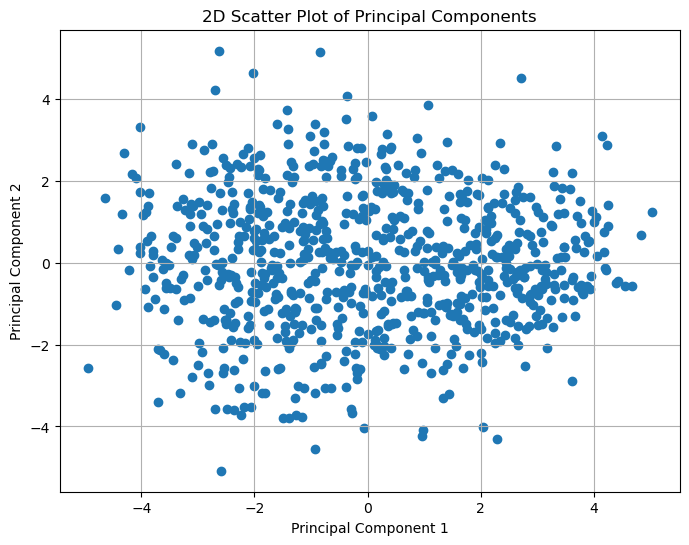

In [7]:
from torch.utils.data import DataLoader 
import torch.nn as nn
import copy
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


dim_emb = 128
dim_hidden = 128 
num_encoders = 2 
drop_prob = 0.2     
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_function = torch.nn.BCEWithLogitsLoss()
bert_test = BERT(vocab_size=len(vocabulary_geno), dim_embedding = dim_emb, dim_hidden=dim_hidden, attention_heads=8, num_encoders=num_encoders, dropout_prob=drop_prob, num_ab=len(vocabulary_pheno), device=device).to(device)
optimizer = torch.optim.AdamW(bert_test.parameters(), lr=0.001, weight_decay=0.01)
criterion = nn.CrossEntropyLoss(ignore_index = -1).to(device)
train_set.prepare_dataset()

loader = DataLoader(train_set, batch_size=32, shuffle=False)
pca = PCA(n_components=2)
cls_tokens = []


for i, batch in enumerate(loader):
    if i ==1000 :
        break
    input, token_target, attn_mask, AB_idx, SR_class = batch

    token_predictions, resistance_predictions, cls_s = bert_test(input, attn_mask) 
    cls_tokens.append(cls_s)

# Concatenate the cls_s tensors across batches into a single tensor
cls_tokens = torch.cat(cls_tokens, dim=0)
print(cls_tokens.shape)

array_2d = cls_tokens.detach().numpy()

# Create DataFrame from NumPy array
df = pd.DataFrame(array_2d)

principalComponents = pca.fit_transform(df)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

principalDf.head()


plt.figure(figsize=(8, 6))
plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'])
plt.title('2D Scatter Plot of Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()



torch.Size([800, 128])


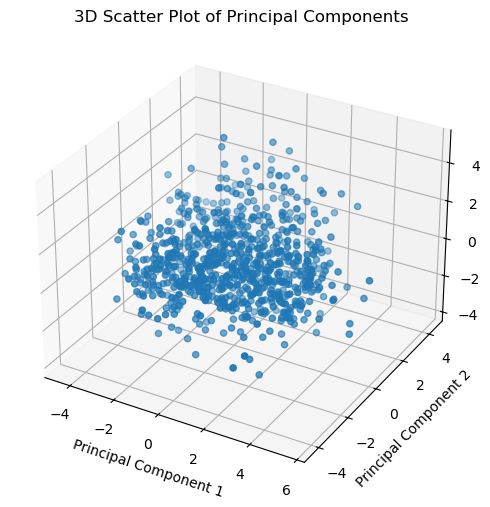

In [12]:

from torch.utils.data import DataLoader 
import torch.nn as nn
import copy
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


dim_emb = 128
dim_hidden = 128 
num_encoders = 2 
drop_prob = 0.2     
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_function = torch.nn.BCEWithLogitsLoss()
bert_test = BERT(vocab_size=len(vocabulary_geno), dim_embedding = dim_emb, dim_hidden=dim_hidden, attention_heads=8, num_encoders=num_encoders, dropout_prob=drop_prob, num_ab=len(vocabulary_pheno), device=device).to(device)
optimizer = torch.optim.AdamW(bert_test.parameters(), lr=0.001, weight_decay=0.01)
criterion = nn.CrossEntropyLoss(ignore_index = -1).to(device)
train_set.prepare_dataset()

loader = DataLoader(train_set, batch_size=32, shuffle=False)
pca = PCA(n_components=3)
cls_tokens = []


for i, batch in enumerate(loader):
    if i ==1000 :
        break
    input, token_target, attn_mask, AB_idx, SR_class = batch

    token_predictions, resistance_predictions, cls_s = bert_test(input, attn_mask) 
    cls_tokens.append(cls_s)

# Concatenate the cls_s tensors across batches into a single tensor
cls_tokens = torch.cat(cls_tokens, dim=0)
print(cls_tokens.shape)

array_2d = cls_tokens.detach().numpy()

# Create DataFrame from NumPy array
df = pd.DataFrame(array_2d)

principalComponents = pca.fit_transform(df)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

principalDf.head()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for principal component 1, 2, and 3
ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'], principalDf['principal component 3'])

# Set labels and title
ax.set_title('3D Scatter Plot of Principal Components')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Show grid
ax.grid(True)

# Show plot
plt.show()

In [11]:
principalDf.head()

,principal component 1,principal component 2,principal component 2
0,-1.894701,-1.424547,1.896699
1,-1.228816,0.141679,-0.424267
2,-2.799160,-1.339685,1.253080
3,-2.181772,-0.191211,-0.325736
4,1.827137,0.912465,1.753572


In [6]:
import torch

from torch import nn
import torch.nn.functional as f
from embedding import JointEmbedding

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class AttentionHead(nn.Module):

    def __init__(self, dim_embedding, drop_prob):
        super(AttentionHead, self).__init__()

        self.dim_embedding = dim_embedding
        self.dropout = nn.Dropout(drop_prob)
        self.q = nn.Linear(self.dim_embedding, self.dim_embedding)
        self.k = nn.Linear(self.dim_embedding, self.dim_embedding)
        self.v = nn.Linear(self.dim_embedding, self.dim_embedding)

    def forward(self, input_tensor: torch.Tensor, attention_mask: torch.Tensor = None):
        query, key, value = self.q(input_tensor), self.k(input_tensor), self.v(input_tensor)

        scale = query.size(1) ** 0.5
        scores = torch.matmul(query, key.transpose(-1, -2)) / scale

        scores = scores.masked_fill_(attention_mask, -1e9)
        attn = f.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        context = torch.matmul(attn, value)

        return context


class MultiHeadAttention(nn.Module):

    def __init__(self, num_heads, dim_embedding, drop_prob):
        super(MultiHeadAttention, self).__init__()

        self.heads = nn.ModuleList([
            AttentionHead(dim_embedding,drop_prob) for _ in range(num_heads)
        ])
        self.linear = nn.Linear(dim_embedding * num_heads, dim_embedding)
        self.norm = nn.LayerNorm(dim_embedding)

    def forward(self, input_tensor: torch.Tensor, attention_mask: torch.Tensor):
        s = [head(input_tensor, attention_mask) for head in self.heads]
        scores = torch.cat(s, dim=-1)
        scores = self.linear(scores)
        return self.norm(scores)

class resEncoder(nn.Module):

    def __init__(self, dim_embedding, attention_heads, dropout_prob):
        super(resEncoder, self).__init__()
        self.dropout_prob = dropout_prob
        self.attention_heads = attention_heads
        self.dim_embedding = dim_embedding
        self.dense = nn.Linear(self.dim_embedding, self.dim_embedding)
        self.layer_norm = nn.LayerNorm(self.dim_embedding)
        self.dropout = nn.Dropout(self.dropout_prob)       
        
        self.attention = MultiHeadAttention(self.attention_heads, self.dim_embedding, self.dropout_prob)  
        self.feed_forward = nn.Sequential(
            nn.Linear(self.dim_embedding, self.dim_embedding),
            nn.GELU(),
            nn.Linear(self.dim_embedding, self.dim_embedding),
            nn.Dropout(self.dropout_prob)
        )
        self.norm = nn.LayerNorm(self.dim_embedding)

    def forward(self, input_tensor: torch.Tensor, attention_mask: torch.Tensor):
        x = input_tensor
        context = self.attention(input_tensor, attention_mask)

        hidden_states = self.dense(context)
        hidden_states = self.dropout(hidden_states)
        x = x + hidden_states
        x = self.layer_norm(x)
        
        res = x
        x = self.feed_forward(x)
        x = x + res
        x = self.layer_norm(x)
        return x

class BERT(nn.Module):

    def __init__(self, vocab_size, dim_embedding, dim_hidden, attention_heads, num_encoders, dropout_prob, num_ab, device):
        super(BERT, self).__init__()
        self.attention_heads = attention_heads
        self.vocab_size = vocab_size
        self.dim_embedding = dim_embedding
        self.dim_hidden = dim_hidden    
        self.num_encoders = num_encoders
        self.dropout_prob = dropout_prob  

        self.embedding = JointEmbedding(self.dim_embedding, self.vocab_size, self.dropout_prob)
        self.encoders = nn.ModuleList([resEncoder(self.dim_embedding, self.attention_heads, self.dropout_prob) for _ in range(self.num_encoders)])
        self.token_prediction_layer = nn.Linear(self.dim_embedding, self.vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)
        
        self.softmax = nn.LogSoftmax(dim=-1)
        self.BC = [BC_Ab(self.dim_embedding, self.dim_hidden).to(device) for _ in range(num_ab)]

    def forward(self, input_tensor: torch.Tensor, attention_mask: torch.Tensor):
        embedded = self.embedding(input_tensor)
        for layer in self.encoders:
            embedded = layer(embedded, attention_mask)
        
        cls_tokens = embedded[:, 0, :]
        resistance_predictions = torch.cat([network(cls_tokens) for network in self.BC], dim=1)
        token_predictions = self.token_prediction_layer(embedded)
        #token_predictions = self.softmax(token_predictions)

        return token_predictions, resistance_predictions, cls_tokens 
    
    def exclude_networks(self, inclusion_list: list):
        indices_to_freeze = [i for i in range(len(self.BC)) if i not in inclusion_list]
        for i, network in enumerate(self.BC):
            if i in indices_to_freeze:
                for param in network.parameters():
                    param.requires_grad = False

    def reset_exclusion(self):
        for network in self.BC:
            for param in network.parameters():
                param.requires_grad = True
    
    def pretrain_freezing(self):
        for network in self.BC:
            for param in network.parameters():
                param.requires_grad = False
        print(f"Parallell networks are frozen")
    
    def finetune_unfreezeing(self):
        for network in self.BC:
            for param in network.parameters():
                param.requires_grad = True
        print(f"Parallell networks are trainable")

class BC_Ab(nn.Module): 
    def __init__(self, emb_dim: int, hidden_dim: int):
        super(BC_Ab, self).__init__()
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        
        self.classifier = nn.Sequential(
            nn.Linear(self.emb_dim, self.hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(self.hidden_dim),
            nn.Linear(self.hidden_dim, 1), # binary classification (S:0 | R:1)
        )
           
    def forward(self, X):
        # X is the CLS token of the BERT model
        return self.classifier(X)

------------------------------